In [1]:
# Leo Simpson, University of Freiburg, Tool-Temp AG, 2023

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
import sys, os
from os.path import join, dirname
main_dir = dirname(os.getcwd())
sys.path.append(main_dir)

In [4]:
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import casadi as ca # type: ignore
import si4kalman
from time import time
rng = np.random.default_rng(seed=42)

# Define the model

In [10]:
dt = 1.
beta_min = 1e-6
Text = 0.
alpha_max = 0.5

def dynamic(x, u, alpha, beta):
    T1 = u[0]
    T2 = x[0]
    T3 = x[1]
    T4 = x[2]
    a_middle = alpha[0]
    aext = alpha[1]
    nx = 3

    # equations of the system
    T2_plus = T2 + dt * a_middle * (T1 - T2)
    T3_plus = T3 + dt * a_middle * (T2 - T3)
    T4_plus = T4 + dt *( a_middle * (T3 - T4) + aext * (Text - T4))
    
    # construction of the output
    x_plus = ca.vcat([T2_plus, T3_plus, T4_plus])
    y = ca.vcat([T2, T4])
    ny = 2
    
    # noise model
    Q =  beta[0] *  ca.DM.eye(nx)
    R =  beta[1] *  ca.DM.eye(ny)
    
    # inequality constraints on the form h > 0
    h = ca.vertcat(alpha, alpha_max - alpha, beta - beta_min)
    return x_plus, y, Q, R, h

In [13]:
# Define the model with Casadi symbolics
x_symbol = ca.SX.sym("x", 3)
u_symbol = ca.SX.sym("u", 1)
alpha_symbol = ca.SX.sym("alpha", 2)
beta_symbol = ca.SX.sym("beta", 2)
xplus_symbol, y_symbol, Q_symbol, R_symbol, h_symbol = dynamic(x_symbol, u_symbol, alpha_symbol, beta_symbol)

In [21]:
# Define a Casadi functions associated with the model
xplus_fn = ca.Function("xplus", [x_symbol, u_symbol, alpha_symbol], [xplus_symbol])
y_fn = ca.Function("y", [x_symbol], [y_symbol])
Q_fn = ca.Function("Q", [beta_symbol], [Q_symbol])
R_fn = ca.Function("R", [beta_symbol], [R_symbol])
h_fn = ca.Function("h", [alpha_symbol, beta_symbol], [h_symbol])

# Generate the problem

## Define the true model 

In [22]:
# make model Parser
model_true = si4kalman.ModelParser(xplus_fn, y_fn, Q_fn, R_fn)

alpha_true = rng.random(model_true.nalpha)* alpha_max # choose a "true parameter randomly"
beta_true = np.array([1e-1, 1e-2]) # Q, R

In [23]:
x0 = np.zeros(model_true.nx)
P0 = np.eye(model_true.nx) * 0.

## Generate Data 

In [24]:
Ntest = 100
Ntrain = 1000
umax = 50

us_train = model_true.generate_u(rng, Ntrain, umax=umax, step = 10)
ys_train, _ = model_true.simulation(x0, us_train, alpha_true,  beta_true, rng)

us_test = model_true.generate_u(rng, Ntest, umax=umax, step = 10)
ys_test, _ = model_true.simulation(x0, us_test, alpha_true, beta_true, rng)

<IPython.core.display.Javascript object>


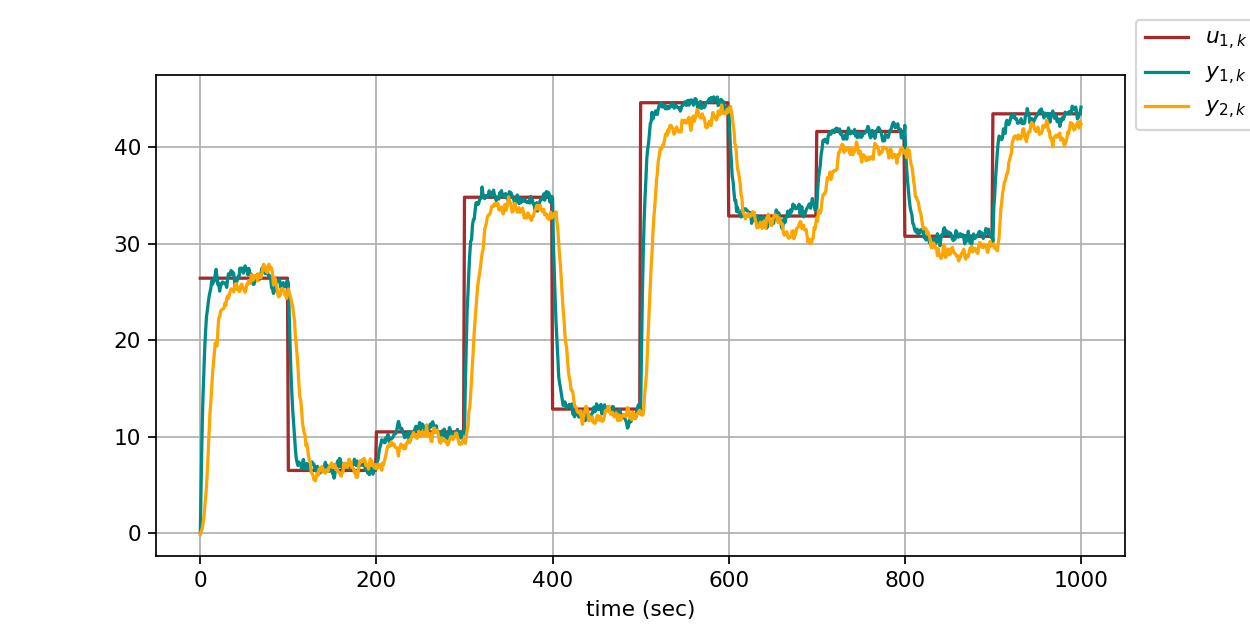

In [25]:
fig = si4kalman.plot_data(us_train, ys_train)

# Estimation

In [26]:
# Here we use the model that is assumed
model = si4kalman.ModelParser(xplus_fn, y_fn, Q_fn, R_fn)
model.Ineq = h_fn
assert model.feasible(alpha_true, beta_true), "Constraints should be satisfied for the true parameters"

In [27]:
# the flag lti allow to speed things up for LTI systems 
problemTrain = si4kalman.ProblemParser(model, ys_train, us_train, x0, P0, lti=True)
problemTest = si4kalman.ProblemParser(model, ys_test, us_test, x0, P0)

In [28]:
# define the initial point for optimization
beta0 = np.ones(model.nbeta)
alpha0 = rng.random(model.nalpha)* alpha_max

## Optimize over the Kalman filter 

In [29]:
formulation = "ExactSQP" # can be "ExactSQP", "ApproxSQP", "ExactIPOPT", "ApproxIPOPT"
opts = {"pen_step":1e-4, "maxiter":20, "tol.direction":0., "tol.kkt":1e-8} # these are parameters of the SQP algorithm

In [30]:
t0 = time()
alpha_found, beta_found, stats = problemTrain.solve(alpha0, beta0, formulation, opts, verbose=False)
rtime = time() - t0
print("running time : {:.2e}  status : {}".format(rtime, stats["return_status"]))

running time : 2.46e+00  status : rtol.cost_decrease


In [31]:
print( alpha_true, alpha_found)
print(beta_true, beta_found)

[0.20926539 0.00769833] [0.21183295 0.00840335]
[0.1  0.01] [0.10114404 0.01145426]


### Validation on out-of-sample data 

In [32]:
xs_est, ys_est = problemTest.kalman(alpha_found, beta_found)

npred = 3
t_pred, y_pred =  model.predictions(us_test, xs_est, alpha_found, npred)

<IPython.core.display.Javascript object>


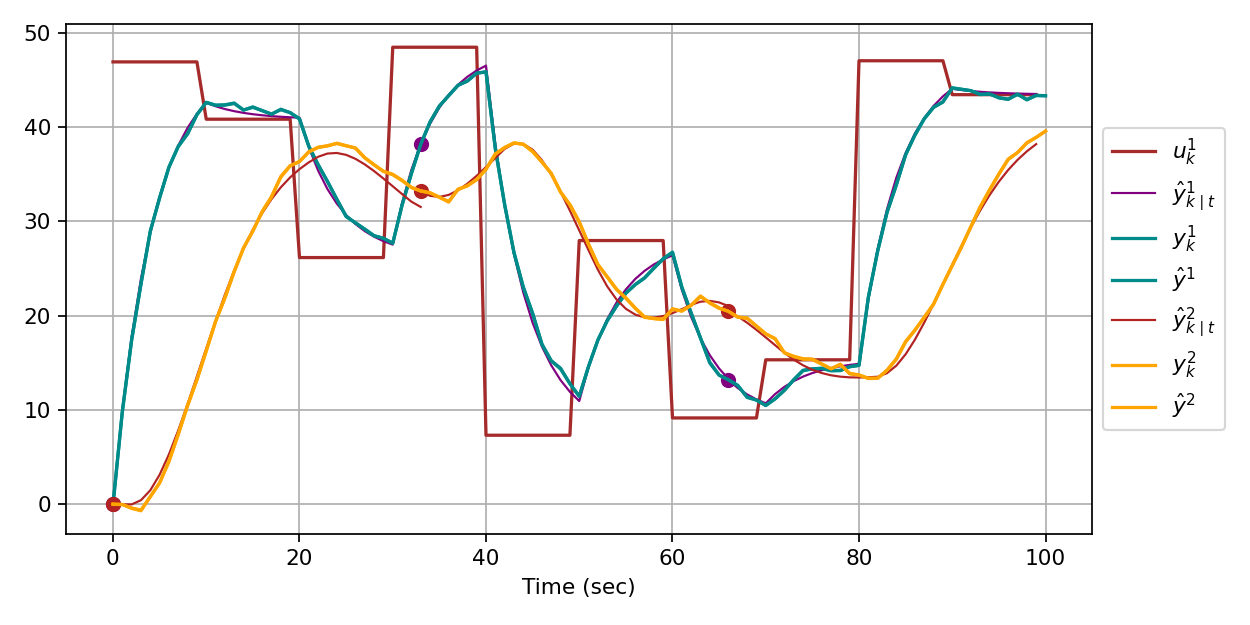

In [33]:
fig = si4kalman.plot_est(us_test, ys_test, ys_est, pred=(t_pred, y_pred))